# Rede Convolucional similar a LeNet aplicada no MNIST

Neste notebook iremos utilizar uma rede convolucional similar à rede LeNet para treinar e classificar o conjunto de dados do MNIST.

In [8]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN,device=gpu0,floatX=float32'

In [1]:
%matplotlib inline
import matplotlib.pyplot as plot
from IPython import display

import time
import numpy as np
import scipy
import argparse

import sys
import tensorflow as tf

import keras
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers.core import Dropout

from keras.optimizers import SGD, RMSprop
from keras.callbacks import Callback
from keras.callbacks import History
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
from keras.utils import np_utils

print('Keras ', keras.__version__)
# print('Theano', theano.__version__)
print('TensorFlow', tf.__version__)
print('Numpy ', np.__version__)

Using TensorFlow backend.


Keras  2.0.3
TensorFlow 1.0.0
Numpy  1.11.3


In [2]:
import keras.backend as K

K.set_image_data_format('channels_first')
K.set_floatx('float32')

print('Backend:     {}'.format(K.backend()))
print('Data format: {}'.format(K.image_data_format()))


Backend:     tensorflow
Data format: channels_first


## Leitura do dataset MNIST

In [3]:
sys.path.append('../src')
from keras.datasets import mnist
from my_keras_utilities import (load_model_and_history, 
                                save_model_and_history, 
                                TrainingPlotter)

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.reshape(-1, 1, 28, 28) / 255.0
X_test = X_test.reshape(-1, 1, 28, 28) / 255.0

## Pequena amostra, apenas para testar o código

In [4]:
n_samples_train = 1000
n_samples_test  = 500

X_train = X_train[:n_samples_train]
y_train = y_train[:n_samples_train]
X_test = X_test[:n_samples_test]
y_test = y_test[:n_samples_test]

## Conventendo para one-hot encoding

In [5]:
y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1000, 1, 28, 28) (500, 1, 28, 28)
(1000, 10) (500, 10)


## Criação do modelo da rede

In [6]:
model_name = '../../models/keras_lenet_1'

class MyLeNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model
        model = Sequential()
        
        # first set of CONV => RELU => POOL
        model.add(Conv2D(20, (5, 5), padding="same", 
                         input_shape=(depth, height, width)))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        # second set of CONV => RELU => POOL
        model.add(Conv2D(50, (5, 5), padding="same"))
        model.add(Activation("relu"))
        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        
        model.add(Dropout(0.5))
        
        # set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(500))
        model.add(Activation("relu"))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model


In [9]:
nepochs = 50

if not os.path.isfile(model_name + '.model'):
    print("[INFO] creating model...")
    model = MyLeNet.build(width=28, height=28, depth=1, classes=10)
    
    # History, checkpoint, earlystop, plot losses:
    my_big_callback = TrainingPlotter(n=1, filepath=model_name, patience=15)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])    
    
else:
    print("[INFO] loading model...")
    model, my_big_callback = load_model_and_history(model_name)
    
print(model.summary())

[INFO] creating model...
[INFO] compiling model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 20, 28, 28)        520       
_________________________________________________________________
activation_1 (Activation)    (None, 20, 28, 28)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 14, 14)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 14, 14)        25050     
_________________________________________________________________
activation_2 (Activation)    (None, 50, 14, 14)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 7, 7)          0         
_________________________________________________________________
dropout_1 (Dropout)      

## Laço de treinamento

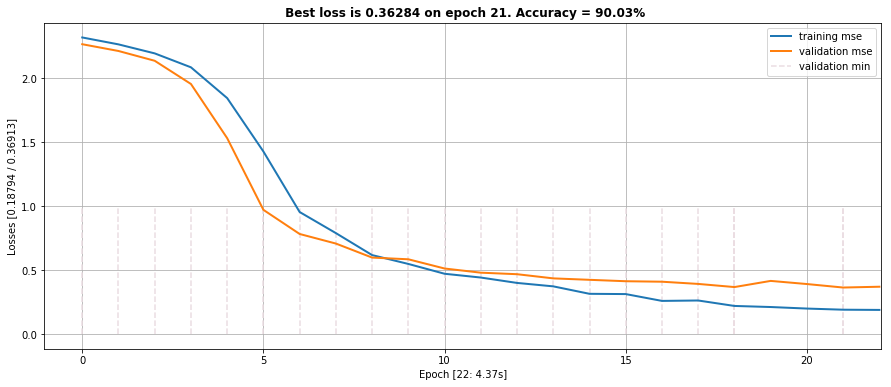

In [10]:
past_epochs = my_big_callback.get_nepochs()

fig = plot.figure(figsize=(15,6))
plot.grid(True)

print("[INFO] training...")
try:
    histo2 = model.fit(X_train, y_train, 
                       batch_size=128, 
                       epochs=nepochs - past_epochs, 
                       verbose=0, 
                       validation_split=0.33, 
                       callbacks=[my_big_callback])
except KeyboardInterrupt:
    pass

In [11]:

print(y_test.shape)

vreal = np.argmax(y_test,axis=1)
print(vreal[:10])

vpred = model.predict_classes(X_test,verbose=0)
print(vpred.shape)
print(vpred[:10])



(500, 10)
[7 2 1 0 4 1 4 9 5 9]
(500,)
[7 2 1 0 4 1 4 9 5 9]


In [12]:
print("[INFO] evaluating in the test data set ...")
loss, accuracy = model.evaluate(X_test, y_test, batch_size=128, verbose=1)
print("\n[INFO] accuracy on the test data set (samples:{}) {:.2f}%".format(X_test.shape[0],accuracy * 100))

[INFO] evaluating in the test data set ...
500/500 [==============================] - 0s     

[INFO] accuracy on the test data set (samples:500) 91.80%


## Mostrando algumas amostras classificadas erroneamente

[ 33  73  80 115 121 124 149 151 167 193 217 233 241 243 245 247 250 268
 290 300 304 318 320 321 325 341 362 376 403 406 435 444 445 448 449 457
 460 479 483 495 497] 41
<class 'numpy.ndarray'>


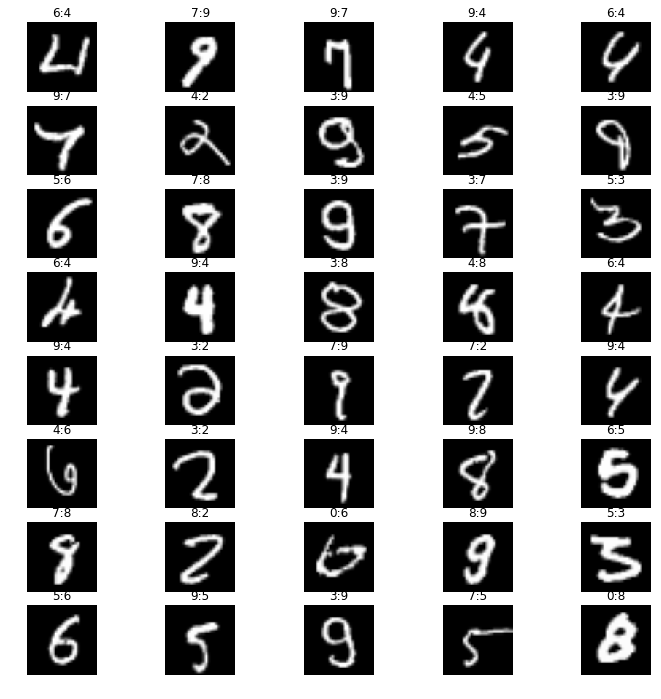

In [13]:
ii = np.where(vpred!=vreal)[0]
print(ii, len(ii))
print(type(ii))

# randomly select a few testing digits
plot.figure(figsize=(12, 12))

import scipy.misc as si

for k, i in enumerate(ii[:40]):
    plot.subplot(8, 5, k + 1)
    # classify the digit
    probs = model.predict(X_test[np.newaxis, i])
    prediction = probs.argmax(axis=1)

    image = (X_test[i][0] * 255).astype("uint8")
    image = si.imresize(image, (96, 96), interp='bilinear')

    # show the image and prediction
    vreal = np.argmax(y_test[i])
    plot.imshow(image,cmap='gray')
    plot.axis('off')
    plot.title('{}:{}'.format(prediction[0],vreal))


## Atividades

1. Calcular o número de parâmetros a serem treinados nesta rede e verificar se confere com o sumário da rede
2. Mostrar a matriz de confusão da rede aplicada no conjunto de testes
2. Mostrar algumas imagens classificadas corretamente, pelo menos uma de cada classe

## Aprendizados com este notebook
